This notebook tries to extend the results from the adversarial spheres paper: https://arxiv.org/pdf/1801.02774.pdf

In particular, instead of generating from spheres, we generate from Gaussians
(with the hope that the high dimensionality makes them effectively spheres).

Additionally, study the influence of the scale of the samples.
We study when the samples have norm $O(1)$ (paper) and $O(\sqrt{D})$ (real life).

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

### Data generation utils

In [2]:
def generate_normal_data(dim, s1, s2, num_samples):
    assert num_samples % 2 == 0
    
    xs = np.concatenate([
        np.random.normal(scale=s1, size=(num_samples // 2, dim)),
        np.random.normal(scale=s2, size=(num_samples // 2, dim))
    ])
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

generate_normal_data(dim=2, s1=0.3, s2=0.7, num_samples=4)

(array([[ 0.4134939 ,  0.20448233],
        [ 0.30065963,  0.22048697],
        [-0.13598055, -0.62764689],
        [ 0.12027813, -0.52070325]]),
 array([1, 0, 0, 1]))

### Experiment setup

In [3]:
def run_experiment(
    dim,
    s1,
    s2,
    model_layers,
    train_batch_size,
    train_epochs,
    attack_norm,
    attack_eps,
    attack_eps_step,
    attack_iters,
    attack_batch_size=1024,
    num_train=5 * 10 ** 4,
    num_test=10 ** 4,
    seed=42
):
    """
    Default values for num_train and num_test are size of CIFAR10 dataset.
    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    x_train, y_train = generate_normal_data(
        dim=dim, s1=s1, s2=s2,
        num_samples=num_train,
    )

    x_test, y_test = generate_normal_data(
        dim=dim, s1=s1, s2=s2,
        num_samples=num_test,
    )
    
    model = keras.Sequential(
        [keras.Input(shape=x_train[0].shape)]
        + model_layers
    )
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=["accuracy"]
    )
    model.fit(
        x_train,
        y_train,
        batch_size=train_batch_size,
        epochs=train_epochs,
        validation_data=(x_test, y_test),
        verbose=2,
    )
    model.trainable = False
    
    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=x_test[0].shape,
        nb_classes=2,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        clip_values=[-x_test.max(), x_test.max()],
    )
    art_attack = ProjectedGradientDescent(
        art_model,
        norm=attack_norm,
        eps=attack_eps,
        eps_step=attack_eps_step,
        max_iter=attack_iters,
        batch_size=attack_batch_size,
    )
    
    x_train_adv = art_attack.generate(x_train[:num_test], y=y_train[:num_test])    
    x_test_adv = art_attack.generate(x_test, y=y_test)
    
    _, nat_train_acc = model.evaluate(x_train, y_train, verbose=0)
    _, nat_test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, adv_train_acc = model.evaluate(x_train_adv, y_train[:num_test], verbose=0)
    _, adv_test_acc = model.evaluate(x_test_adv, y_test, verbose=0)
    
    print("Nat train acc :", nat_train_acc)
    print("Nat test  acc :", nat_test_acc)
    print("Adv train acc :", adv_train_acc)
    print("Adv test  acc :", adv_test_acc)
    
    return dict(
        model=model,
        train_data=(x_train, y_train),
        test_data=(x_test, y_test),
        x_train_adv=x_train_adv,
        x_test_adv=x_test_adv,
    )

### Run experiments

Norm $O(1)$

In [4]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0 / np.sqrt(D), s2=1.3 / np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
391/391 - 3s - loss: 0.1461 - accuracy: 0.9361 - val_loss: 0.0479 - val_accuracy: 0.9831
Epoch 2/10
391/391 - 3s - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.0487 - val_accuracy: 0.9814
Epoch 3/10
391/391 - 3s - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.0680 - val_accuracy: 0.9755
Epoch 4/10
391/391 - 3s - loss: 0.0132 - accuracy: 0.9950 - val_loss: 0.1112 - val_accuracy: 0.9655
Epoch 5/10
391/391 - 3s - loss: 0.0085 - accuracy: 0.9970 - val_loss: 0.0363 - val_accuracy: 0.9874
Epoch 6/10
391/391 - 3s - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0380 - val_accuracy: 0.9869
Epoch 7/10
391/391 - 3s - loss: 7.2325e-04 - accuracy: 0.9998 - val_loss: 0.0313 - val_accuracy: 0.9896
Epoch 8/10
391/391 - 3s - loss: 1.8886e-04 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9912
Epoch 9/10
391/391 - 3s - loss: 2.2117e-05 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9907
Epoch 10/10
391/391 - 3s - loss: 1.3367e-05 - accuracy: 1.0000 - val_loss: 0.0245 - val_

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 1.0
Nat test  acc : 0.9908999800682068
Adv train acc : 0.5303999781608582
Adv test  acc : 0.4036000072956085
CPU times: user 9min 46s, sys: 1min 6s, total: 10min 53s
Wall time: 46.9 s


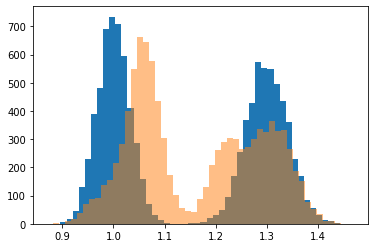

In [5]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

---

Norm $O(\sqrt{D})$

In [6]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0, s2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=20,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/20
391/391 - 3s - loss: 0.6796 - accuracy: 0.5572 - val_loss: 0.6806 - val_accuracy: 0.5149
Epoch 2/20
391/391 - 3s - loss: 0.4695 - accuracy: 0.7730 - val_loss: 0.4105 - val_accuracy: 0.8120
Epoch 3/20
391/391 - 3s - loss: 0.1523 - accuracy: 0.9431 - val_loss: 0.4180 - val_accuracy: 0.8348
Epoch 4/20
391/391 - 3s - loss: 0.0771 - accuracy: 0.9712 - val_loss: 0.3156 - val_accuracy: 0.8835
Epoch 5/20
391/391 - 3s - loss: 0.0501 - accuracy: 0.9819 - val_loss: 0.2828 - val_accuracy: 0.8958
Epoch 6/20
391/391 - 3s - loss: 0.0383 - accuracy: 0.9863 - val_loss: 0.3166 - val_accuracy: 0.8947
Epoch 7/20
391/391 - 3s - loss: 0.0365 - accuracy: 0.9863 - val_loss: 0.2922 - val_accuracy: 0.8952
Epoch 8/20
391/391 - 3s - loss: 0.0336 - accuracy: 0.9876 - val_loss: 0.2575 - val_accuracy: 0.9077
Epoch 9/20
391/391 - 3s - loss: 0.0267 - accuracy: 0.9905 - val_loss: 0.3264 - val_accuracy: 0.8898
Epoch 10/20
391/391 - 3s - loss: 0.0269 - accuracy: 0.9902 - val_loss: 0.2439 - val_accuracy: 0.9153

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.996399998664856
Nat test  acc : 0.9375
Adv train acc : 0.5031999945640564
Adv test  acc : 0.24770000576972961
CPU times: user 16min 4s, sys: 1min 41s, total: 17min 45s
Wall time: 1min 13s


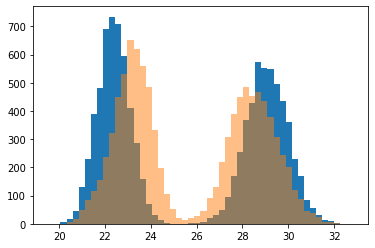

In [7]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

---

Norm $O(1)$ + BatchNorm

In [8]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0 / np.sqrt(D), s2=1.3 / np.sqrt(D),
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1,
    attack_eps_step=0.01,
    attack_iters=20,
)

Epoch 1/10
391/391 - 4s - loss: 0.0561 - accuracy: 0.9789 - val_loss: 0.2016 - val_accuracy: 0.9182
Epoch 2/10
391/391 - 4s - loss: 0.0223 - accuracy: 0.9920 - val_loss: 0.0302 - val_accuracy: 0.9888
Epoch 3/10
391/391 - 4s - loss: 0.0182 - accuracy: 0.9934 - val_loss: 0.0333 - val_accuracy: 0.9882
Epoch 4/10
391/391 - 4s - loss: 0.0139 - accuracy: 0.9952 - val_loss: 0.0385 - val_accuracy: 0.9865
Epoch 5/10
391/391 - 4s - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.0387 - val_accuracy: 0.9891
Epoch 6/10
391/391 - 4s - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.0405 - val_accuracy: 0.9884
Epoch 7/10
391/391 - 4s - loss: 0.0112 - accuracy: 0.9961 - val_loss: 0.0514 - val_accuracy: 0.9850
Epoch 8/10
391/391 - 4s - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.0584 - val_accuracy: 0.9826
Epoch 9/10
391/391 - 4s - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0870 - val_accuracy: 0.9781
Epoch 10/10
391/391 - 4s - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.0539 - val_accuracy: 0.9873

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9985399842262268
Nat test  acc : 0.9872999787330627
Adv train acc : 0.5702999830245972
Adv test  acc : 0.5044999718666077
CPU times: user 10min 36s, sys: 1min 22s, total: 11min 58s
Wall time: 56.3 s


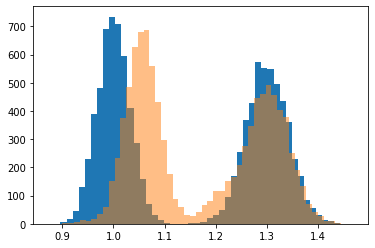

In [9]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

---

Norm $O(\sqrt{D})$ + BatchNorm

In [10]:
%%time
D = 500
res = run_experiment(
    dim=D,
    s1=1.0, s2=1.3,
    model_layers=[
        layers.Dense(1000, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(2),
    ],
    train_batch_size=128,
    train_epochs=10,
    attack_norm=2,
    attack_eps=0.1 * np.sqrt(D),
    attack_eps_step=0.01 * np.sqrt(D),
    attack_iters=20,
)

Epoch 1/10
391/391 - 4s - loss: 0.0991 - accuracy: 0.9658 - val_loss: 0.0769 - val_accuracy: 0.9712
Epoch 2/10
391/391 - 4s - loss: 0.0472 - accuracy: 0.9826 - val_loss: 0.0537 - val_accuracy: 0.9794
Epoch 3/10
391/391 - 4s - loss: 0.0371 - accuracy: 0.9868 - val_loss: 0.0472 - val_accuracy: 0.9828
Epoch 4/10
391/391 - 4s - loss: 0.0324 - accuracy: 0.9882 - val_loss: 0.0511 - val_accuracy: 0.9804
Epoch 5/10
391/391 - 4s - loss: 0.0313 - accuracy: 0.9888 - val_loss: 0.0778 - val_accuracy: 0.9716
Epoch 6/10
391/391 - 4s - loss: 0.0267 - accuracy: 0.9903 - val_loss: 0.0730 - val_accuracy: 0.9755
Epoch 7/10
391/391 - 4s - loss: 0.0255 - accuracy: 0.9906 - val_loss: 0.0652 - val_accuracy: 0.9807
Epoch 8/10
391/391 - 4s - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0567 - val_accuracy: 0.9812
Epoch 9/10
391/391 - 4s - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.0640 - val_accuracy: 0.9798
Epoch 10/10
391/391 - 4s - loss: 0.0228 - accuracy: 0.9923 - val_loss: 0.0665 - val_accuracy: 0.9794

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

Nat train acc : 0.9948599934577942
Nat test  acc : 0.9793999791145325
Adv train acc : 0.5489000082015991
Adv test  acc : 0.44339999556541443
CPU times: user 10min 39s, sys: 1min 24s, total: 12min 3s
Wall time: 56.7 s


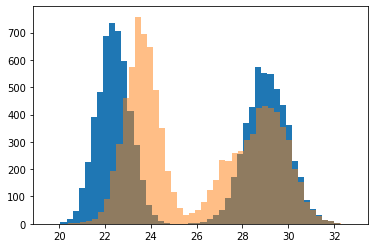

In [11]:
plt.hist(np.linalg.norm(res["test_data"][0], ord=2, axis=-1), bins=50, label="x_test");
plt.hist(np.linalg.norm(res["x_test_adv"], ord=2, axis=-1), bins=50, label="x_test_adv", alpha=0.5);

### Summary and conclusions
Overall we get pretty similar behavior in the spherical and Gaussian cases (see sphere-v1.ipynb).

Like in the spherical case,
the vanilla feed-forward NN does worse on norm-$O(\sqrt{D})$ data than norm-$O(1)$ data
(93% test acc vs 99% test acc).
However, this difference can be mitigated with a batchnorm layer.